# Exploratoy Data Analysis (EDA)

##### Setups & Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm

# Load Preprocessed Data
df = pd.read_csv('../data/processed/processed_data.csv', parse_dates=['Date'], index_col='Date')
print(f"Data loaded with shape: {df.shape}")


Data loaded with shape: (2505, 30)


##### Basic Data Inspection

In [3]:
print("\n=== Data Structure ===")
print(df.info())

print("\n=== Missing Values ===")
print(df.isnull().sum())


=== Data Structure ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2505 entries, 2015-08-13 to 2025-07-30
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open_TSLA         2505 non-null   float64
 1   High_TSLA         2505 non-null   float64
 2   Low_TSLA          2505 non-null   float64
 3   Close_TSLA        2505 non-null   float64
 4   Volume_TSLA       2505 non-null   int64  
 5   Open_BND          2505 non-null   float64
 6   High_BND          2505 non-null   float64
 7   Low_BND           2505 non-null   float64
 8   Close_BND         2505 non-null   float64
 9   Volume_BND        2505 non-null   int64  
 10  Open_SPY          2505 non-null   float64
 11  High_SPY          2505 non-null   float64
 12  Low_SPY           2505 non-null   float64
 13  Close_SPY         2505 non-null   float64
 14  Volume_SPY        2505 non-null   int64  
 15  Return_TSLA       2505 non-null   float64
 16  

##### Statistical Overview

In [4]:
def highlight_extremes(s):
    is_max = s == s.max()
    is_min = s == s.min()
    return ['background-color: brown' if v else '' for v in (is_max | is_min)]

print("\n=== Descriptive Statistics ===")
display(df[[col for col in df.columns if 'Close_' in col]].describe().style.apply(highlight_extremes))



=== Descriptive Statistics ===


,Close_TSLA,Close_BND,Close_SPY
count,2505.000000,2505.000000,2505.000000
mean,133.372183,68.558049,336.013371
std,121.102192,4.513335,125.955580
min,9.488000,61.174302,155.426500
25%,19.405333,64.730476,233.814207
50%,101.267334,67.696037,308.647087
75%,236.889999,71.910235,421.629238
max,475.899994,77.378741,638.349976


##### Price Trend Visualization

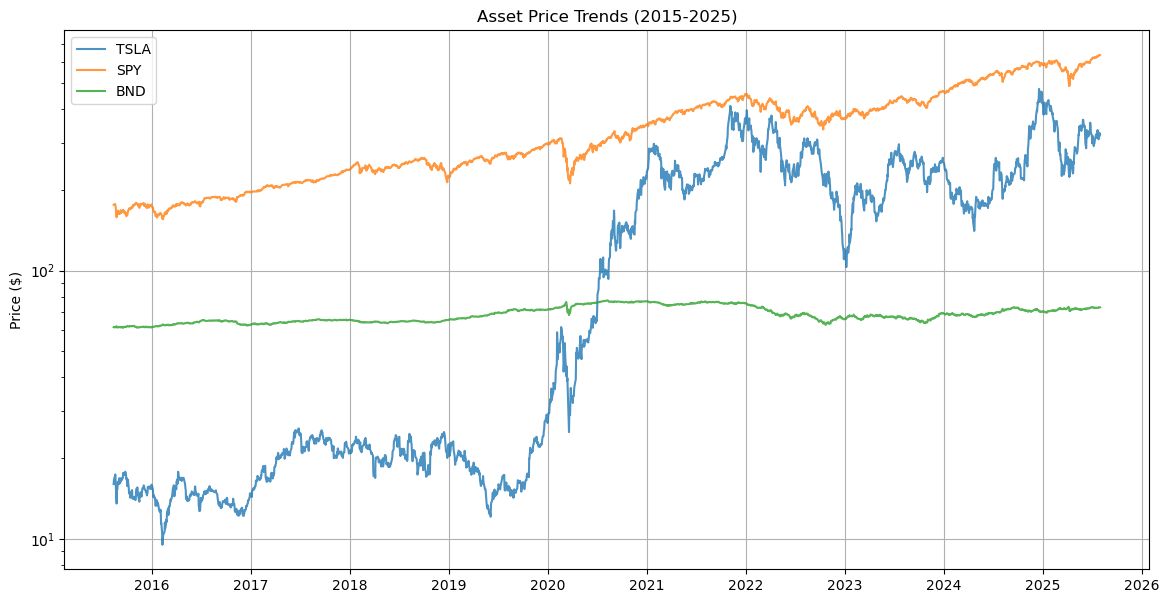

In [5]:
plt.figure(figsize=(14, 7))
for ticker in ['TSLA', 'SPY', 'BND']:
    plt.plot(df.index, df[f'Close_{ticker}'], label=ticker, alpha=0.8)
plt.title('Asset Price Trends (2015-2025)')
plt.ylabel('Price ($)')
plt.yscale('log')  # Better for comparing growth rates
plt.legend()
plt.grid(True)
plt.show()

##### Returns Analysis

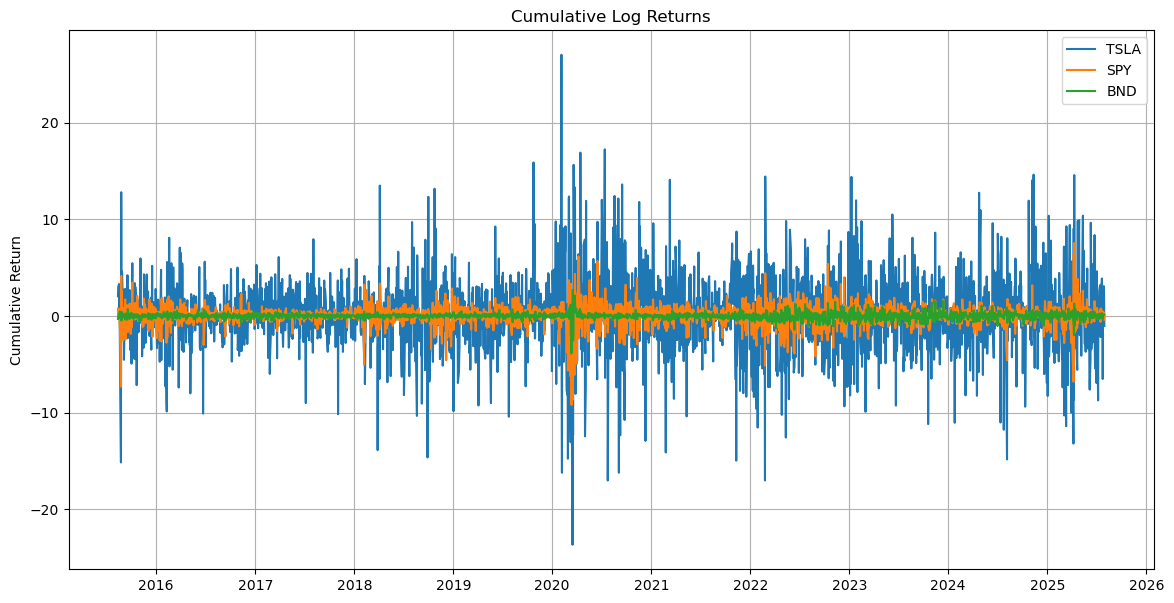

In [9]:
plt.figure(figsize=(14, 7))
for ticker in ['TSLA', 'SPY', 'BND']:
    plt.plot(df.index, df[f'LogReturn_{ticker}']*100, label=ticker)
plt.title('Cumulative Log Returns')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

##### Volatility Analysis

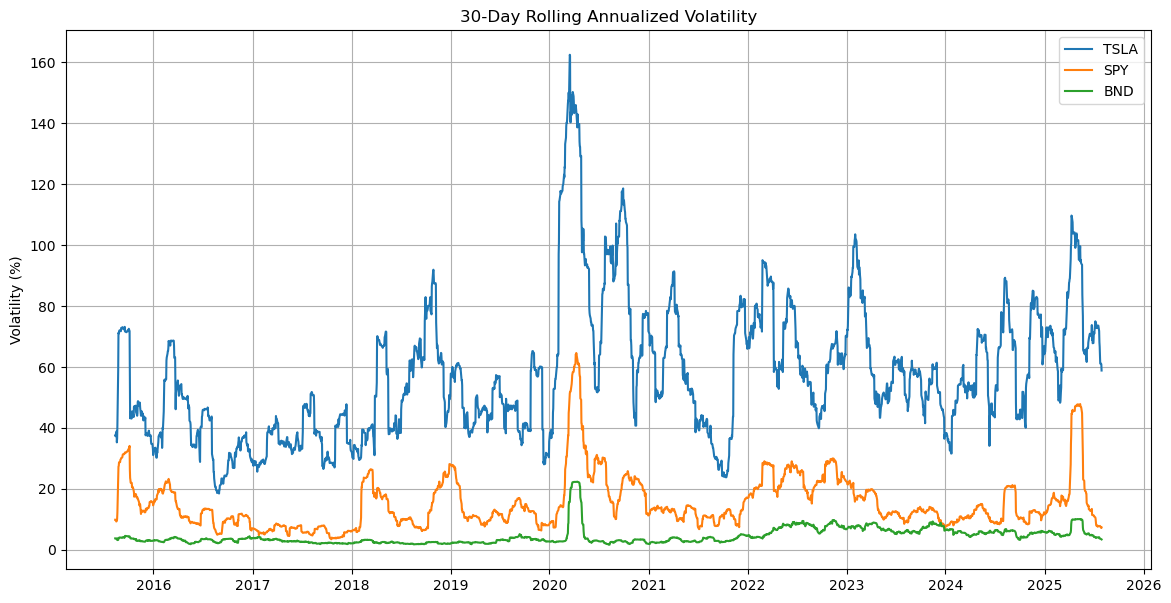

In [ ]:
plt.figure(figsize=(14, 7))
for ticker in ['TSLA', 'SPY', 'BND']:
    plt.plot(df.index, df[f'Volatility_{ticker}']*100, label=ticker)
plt.title('30-Day Rolling Annualized Volatility')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()

##### Stationarity Tests

In [19]:
def adf_test(series):
    result = adfuller(series.dropna())
    return pd.Series({
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    })

print("\n=== Stationarity Tests ===")
stationarity_results = pd.DataFrame()
for ticker in ['TSLA', 'SPY', 'BND']:
    for series_type in ['Close', 'LogReturn']:
        col_name = f"{series_type}_{ticker}"
        test_result = adf_test(df[col_name])
        stationarity_results.loc[col_name, 'p-value'] = test_result['p-value']
        stationarity_results.loc[col_name, 'Stationary'] = test_result['p-value'] < 0.05
        
display(stationarity_results.style.applymap(lambda x: 'background-color: brown' if x else '', 
                                          subset=['Stationary']))


=== Stationarity Tests ===


C:\Users\user\AppData\Local\Temp\ipykernel_11360\3204724615.py:18: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(stationarity_results.style.applymap(lambda x: 'background-color: brown' if x else '',


,p-value,Stationary
Close_TSLA,0.625826,False
LogReturn_TSLA,0.000000,True
Close_SPY,0.991332,False
LogReturn_SPY,0.000000,True
Close_BND,0.480100,False
LogReturn_BND,0.000000,True


##### Risk Metrics Calculation

In [ ]:
def calculate_var(returns, confidence_level=0.95):
    return np.percentile(returns, (1-confidence_level)*100)

risk_metrics = pd.DataFrame()
for ticker in ['TSLA', 'SPY', 'BND']:
    returns = df[f'LogReturn_{ticker}']
    risk_metrics.loc[ticker, 'Annual Return'] = returns.mean() * 252
    risk_metrics.loc[ticker, 'Annual Volatility'] = returns.std() * np.sqrt(252)
    risk_metrics.loc[ticker, 'Sharpe Ratio'] = risk_metrics.loc[ticker, 'Annual Return'] / risk_metrics.loc[ticker, 'Annual Volatility']
    risk_metrics.loc[ticker, 'VaR (95%)'] = calculate_var(returns)
    risk_metrics.loc[ticker, 'Max Drawdown'] = (returns.cumsum().expanding().max() - returns.cumsum()).max()

print("\n=== Risk Metrics ===")
display(risk_metrics.style.background_gradient(cmap='RdYlGn', axis=0))



=== Risk Metrics ===


,Annual Return,Annual Volatility,Sharpe Ratio,VaR (95%),Max Drawdown
TSLA,0.304168,0.619794,0.490757,-0.058571,1.385007
SPY,0.130038,0.177027,0.734568,-0.017673,0.386383
BND,0.016829,0.052212,0.322312,-0.004689,0.209823


##### Outlier Detection

In [ ]:
print("\n=== Significant Return Days ===")
for ticker in ['TSLA', 'SPY', 'BND']:
    std_dev = df[f'LogReturn_{ticker}'].std()
    outliers = df[abs(df[f'LogReturn_{ticker}']) > 3*std_dev]
    print(f"\n{ticker} Days with >3σ Returns ({len(outliers)} events):")
    display(outliers[[f'LogReturn_{ticker}']].sort_values(f'LogReturn_{ticker}'))


=== Significant Return Days ===

TSLA Days with >3σ Returns (47 events):


,LogReturn_TSLA
Date,
2020-03-16,-0.236893
2020-07-24,-0.170326
2022-02-24,-0.170306
2020-02-06,-0.162306
2020-09-03,-0.162302
2015-08-24,-0.151661
2021-11-10,-0.149720
2024-08-05,-0.148535
2020-02-28,-0.147801



SPY Days with >3σ Returns (40 events):


,LogReturn_SPY
Date,
2020-03-12,-0.092109
2020-03-16,-0.086953
2015-08-24,-0.073205
2025-04-07,-0.068111
2020-03-09,-0.062823
2020-03-23,-0.060947
2020-02-28,-0.056431
2025-04-09,-0.055998
2022-02-24,-0.051311



BND Days with >3σ Returns (36 events):


,LogReturn_BND
Date,
2020-03-12,-0.038769
2020-03-18,-0.025579
2020-03-13,-0.021675
2020-03-19,-0.021095
2020-03-10,-0.020601
2025-04-09,-0.019805
2022-06-13,-0.014050
2022-04-06,-0.012611
2022-08-03,-0.011218


##### Correlation Analysis

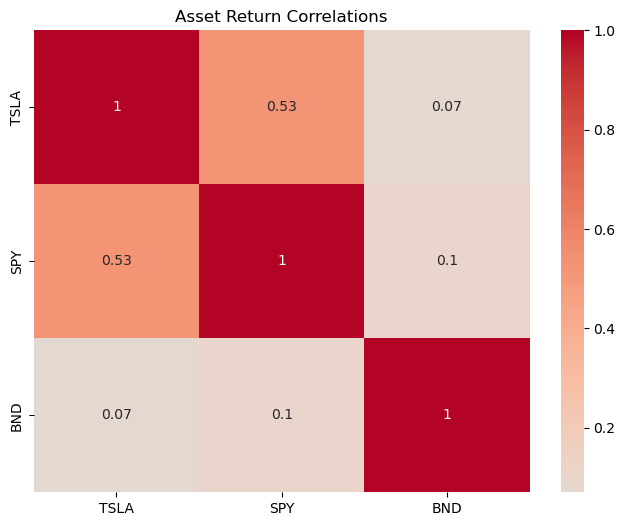

In [ ]:
corr_matrix = df[[f'LogReturn_{ticker}' for ticker in ['TSLA', 'SPY', 'BND']]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            xticklabels=['TSLA', 'SPY', 'BND'], yticklabels=['TSLA', 'SPY', 'BND'])
plt.title('Asset Return Correlations')
plt.show()